The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Saving news-zensus-2022-miete.xlsx to news-zensus-2022-miete (2).xlsx
=== SQL DATA VALIDATION ===
Missing data analysis:
   total_districts  missing_pre_1950  missing_1950_1969  missing_1970_1989  \
0               20                 8                  8                  8   

   missing_1990_2009  missing_2010_plus  
0                  8                  8  

=== SQL BASIC STATISTICS ===
Basic statistics:
      period  avg_rent  min_rent  max_rent  count_districts
0   Pre-1950      7.79      7.15      8.35               12
1  1950-1969      6.97      6.15      8.11               12
2  1970-1989      6.86      5.85      8.33               12
3  1990-2009      8.63      7.04     10.14               12
4      2010+     12.39      9.70     16.26               12

=== SQL EXTREME VALUES ANALYSIS ===
Extreme values:
                   category                   Stadtteil  value
0   Most Expensive Pre-1950                      Pankow   8.35
1   Most Expensive Pre-1950    Friedrichshain-Kreuz

<Figure size 1400x1000 with 0 Axes>

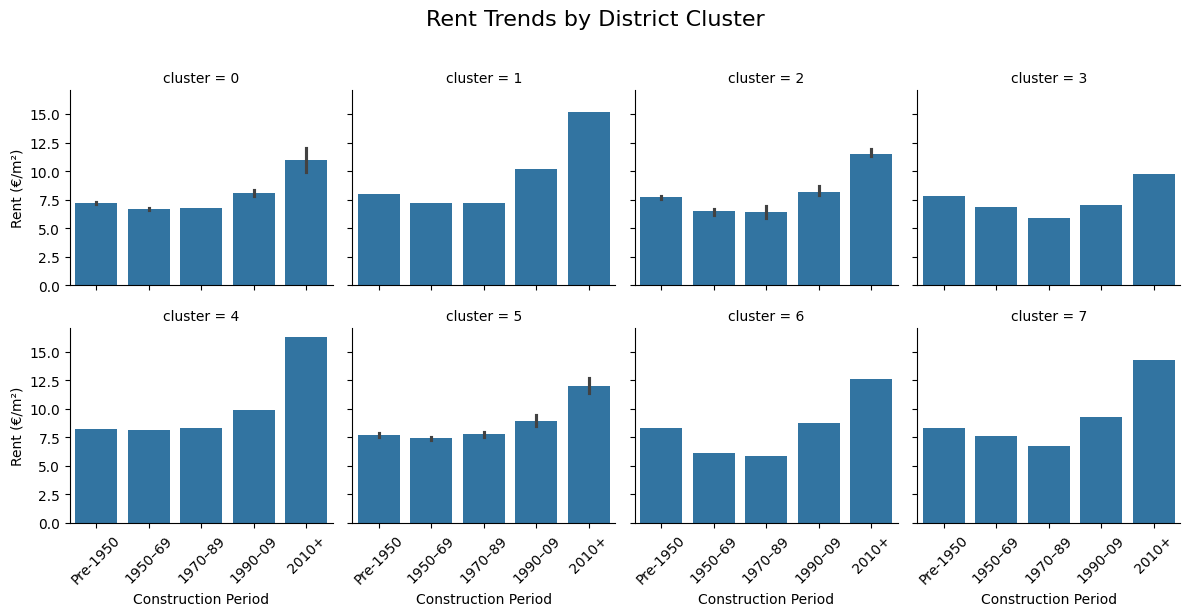

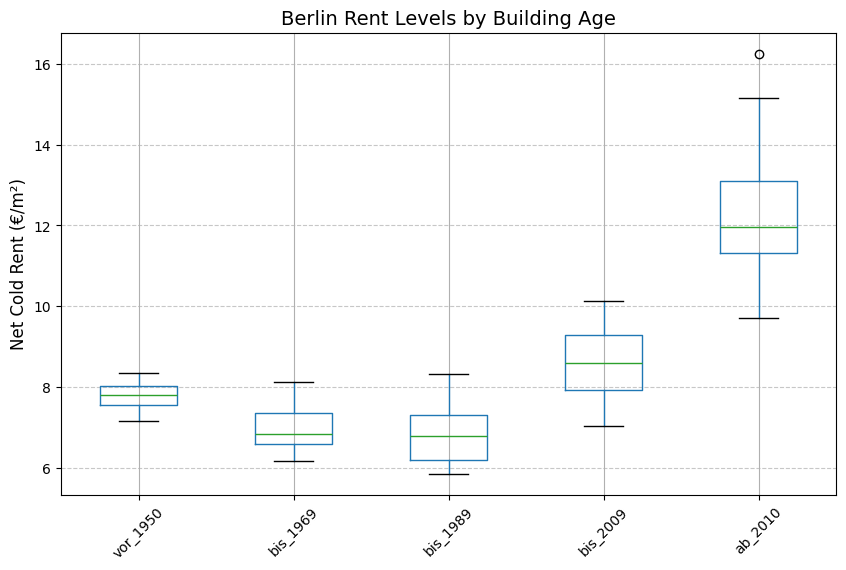

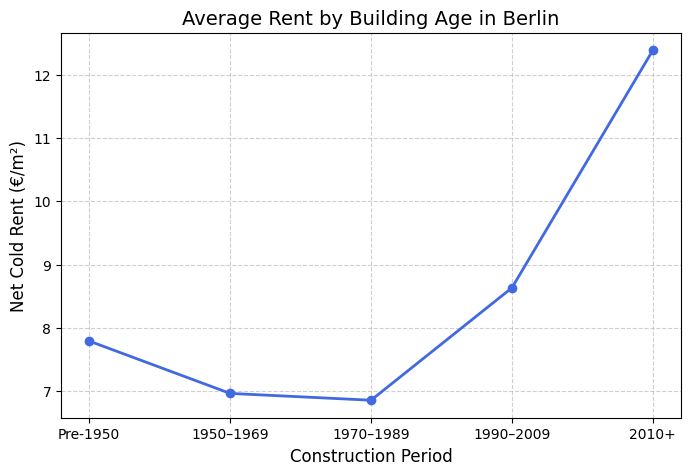

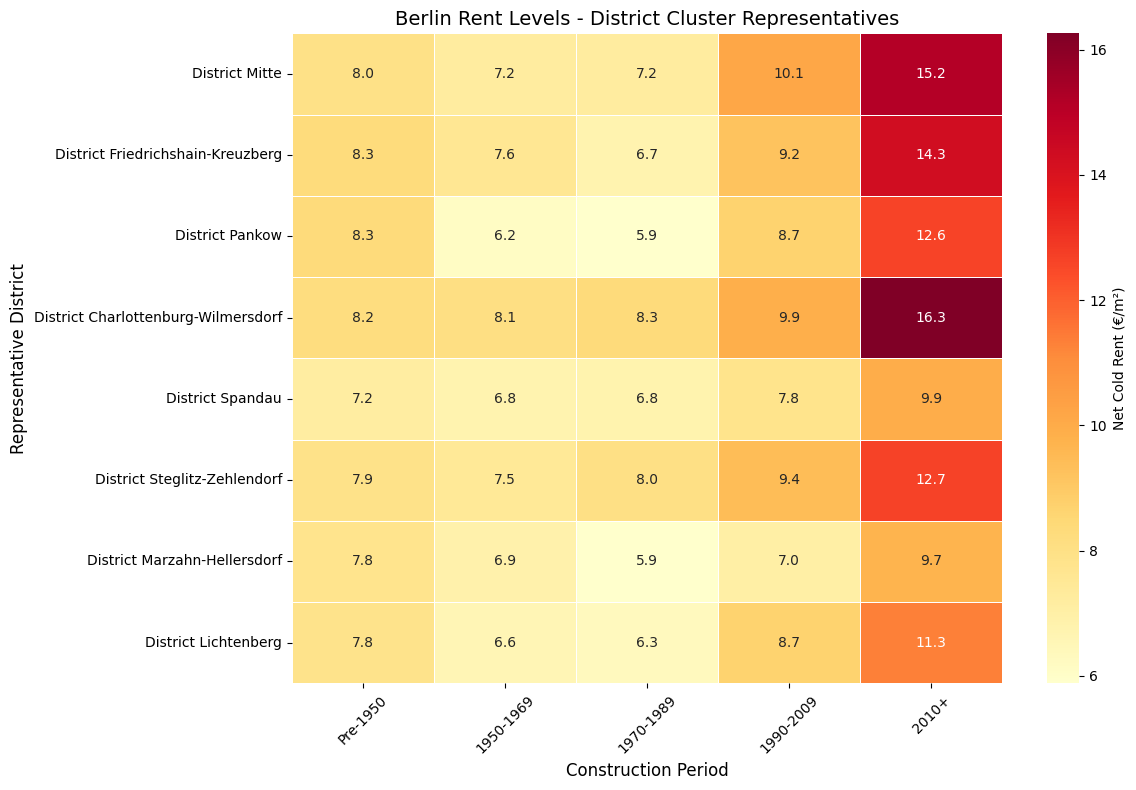


=== FINAL SQL SUMMARY ===
Final summary:
            statistic  pre_1950  _1950_1969  _1970_1989  _1990_2009  \
0             Overall      7.79        6.97        6.86        8.63   
1  Price Increase (%)       NaN         NaN         NaN         NaN   

   _2010_plus  
0       12.39  
1        0.00  

ANALYSIS COMPLETE! Hybrid SQL + Python approach successful!


In [6]:
# -*- coding: utf-8 -*-
"""Hybrid SQL + Python Berlin Rent Analysis"""

# Installations
!pip install ipython-sql openpyxl plotly
%load_ext sql
%sql sqlite:///berlin_housing.db

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from google.colab import files

# Upload and process the Excel file
uploaded = files.upload()

# Read and clean data using Python (better for messy Excel files)
df_berlin = pd.read_excel("news-zensus-2022-miete.xlsx",
                          sheet_name="Berlin",
                          skiprows=5)
df_berlin = df_berlin.drop(df_berlin.columns[1], axis=1)
df_berlin.columns = [
    "Stadtteil",
    "vor_1950",
    "bis_1969",
    "bis_1989",
    "bis_2009",
    "ab_2010"
]

# Use SQL for data storage and basic queries
from sqlalchemy import create_engine
engine = create_engine('sqlite:///berlin_housing.db')
df_berlin.to_sql('berlin_rents', engine, if_exists='replace', index=False)

# ===== SQL FOR DATA VALIDATION AND BASIC ANALYSIS =====
print("=== SQL DATA VALIDATION ===")

# Use pandas to execute SQL queries
def run_sql_query(query):
    """Execute SQL query and return as DataFrame"""
    return pd.read_sql_query(query, engine)

# Check for missing data
missing_data_query = """
SELECT
    COUNT(*) as total_districts,
    SUM(CASE WHEN "vor_1950" IS NULL THEN 1 ELSE 0 END) as missing_pre_1950,
    SUM(CASE WHEN "bis_1969" IS NULL THEN 1 ELSE 0 END) as missing_1950_1969,
    SUM(CASE WHEN "bis_1989" IS NULL THEN 1 ELSE 0 END) as missing_1970_1989,
    SUM(CASE WHEN "bis_2009" IS NULL THEN 1 ELSE 0 END) as missing_1990_2009,
    SUM(CASE WHEN "ab_2010" IS NULL THEN 1 ELSE 0 END) as missing_2010_plus
FROM berlin_rents
"""

missing_data = run_sql_query(missing_data_query)
print("Missing data analysis:")
print(missing_data)

# ===== SQL FOR BASIC STATISTICS =====
print("\n=== SQL BASIC STATISTICS ===")

basic_stats_query = """
SELECT
    'Pre-1950' as period,
    ROUND(AVG("vor_1950"), 2) as avg_rent,
    ROUND(MIN("vor_1950"), 2) as min_rent,
    ROUND(MAX("vor_1950"), 2) as max_rent,
    COUNT("vor_1950") as count_districts
FROM berlin_rents
WHERE "vor_1950" IS NOT NULL

UNION ALL

SELECT '1950-1969', ROUND(AVG("bis_1969"), 2), ROUND(MIN("bis_1969"), 2),
       ROUND(MAX("bis_1969"), 2), COUNT("bis_1969")
FROM berlin_rents WHERE "bis_1969" IS NOT NULL

UNION ALL

SELECT '1970-1989', ROUND(AVG("bis_1989"), 2), ROUND(MIN("bis_1989"), 2),
       ROUND(MAX("bis_1989"), 2), COUNT("bis_1989")
FROM berlin_rents WHERE "bis_1989" IS NOT NULL

UNION ALL

SELECT '1990-2009', ROUND(AVG("bis_2009"), 2), ROUND(MIN("bis_2009"), 2),
       ROUND(MAX("bis_2009"), 2), COUNT("bis_2009")
FROM berlin_rents WHERE "bis_2009" IS NOT NULL

UNION ALL

SELECT '2010+', ROUND(AVG("ab_2010"), 2), ROUND(MIN("ab_2010"), 2),
       ROUND(MAX("ab_2010"), 2), COUNT("ab_2010")
FROM berlin_rents WHERE "ab_2010" IS NOT NULL
"""

stats_df = run_sql_query(basic_stats_query)
print("Basic statistics:")
print(stats_df)

# ===== SQL FOR FINDING EXTREMES =====
print("\n=== SQL EXTREME VALUES ANALYSIS ===")

# Fixed approach: Run separate queries for each category
expensive_query = """
SELECT
    'Most Expensive Pre-1950' as category,
    "Stadtteil",
    "vor_1950" as value
FROM berlin_rents
WHERE "vor_1950" IS NOT NULL
ORDER BY "vor_1950" DESC
LIMIT 5
"""

cheapest_query = """
SELECT
    'Cheapest Pre-1950' as category,
    "Stadtteil",
    "vor_1950" as value
FROM berlin_rents
WHERE "vor_1950" IS NOT NULL
ORDER BY "vor_1950" ASC
LIMIT 5
"""

price_jump_query = """
SELECT
    'Largest Price Jump' as category,
    "Stadtteil",
    ("ab_2010" - "vor_1950") as value
FROM berlin_rents
WHERE "ab_2010" IS NOT NULL AND "vor_1950" IS NOT NULL
ORDER BY ("ab_2010" - "vor_1950") DESC
LIMIT 5
"""

# Run each query separately and combine
expensive_df = run_sql_query(expensive_query)
cheapest_df = run_sql_query(cheapest_query)
price_jump_df = run_sql_query(price_jump_query)

# Combine the results
extreme_df = pd.concat([expensive_df, cheapest_df, price_jump_df], ignore_index=True)
print("Extreme values:")
print(extreme_df)

# ===== PYTHON FOR ADVANCED ANALYSIS =====
print("\n=== PYTHON FOR ADVANCED ANALYSIS ===")

# Get all data for Python analysis using SQL
all_data_query = "SELECT * FROM berlin_rents"
combined_df = run_sql_query(all_data_query)

# District name mapping
district_name_map = {
    '12060092': 'Mitte-Zentrum',
    '12060240': 'Mitte-Tiergarten',
    '12061244': 'Mitte-Wedding',
    '12061435': 'Mitte-Gesundbrunnen',
    '12062124': 'Mitte-Moabit',
    '12062293': 'Mitte-Hansaviertel',
    '12062492': 'Friedrichshain-Kreuzberg-Friedrichshain',
    '12063189': 'Friedrichshain-Kreuzberg-Kreuzberg',
    '12064009': 'Pankow-Prenzlauer Berg',
    '12064205': 'Pankow-Weißensee',
    '12064370': 'Pankow-Blankenburg',
    '12064512': 'Pankow-Heinersdorf',
    '12065225': 'Pankow-Karow',
    '12066116': 'Pankow-Stadtrandsiedlung Malchow',
    '12066292': 'Pankow-Buch',
    '12067144': 'Pankow-Französisch Buchholz',
    '12067813': 'Pankow-Niederschönhausen',
    '12068052': 'Pankow-Rosenthal',
    '12068413': 'Pankow-Blankenfelde',
    '12069052': 'Charlottenburg-Wilmersdorf-Charlottenburg',
    '12069448': 'Charlottenburg-Wilmersdorf-Charlottenburg-Nord',
    '12069656': 'Charlottenburg-Wilmersdorf-Grunewald',
    '12070173': 'Charlottenburg-Wilmersdorf-Halensee',
    '12070393': 'Charlottenburg-Wilmersdorf-Schmargendorf',
    '12071164': 'Charlottenburg-Wilmersdorf-Wilmersdorf',
    '12071401': 'Spandau-Spandau',
    '12072297': 'Spandau-Haselhorst',
    '12073216': 'Spandau-Siemensstadt',
    '12073520': 'Spandau-Staaken'
}

combined_df['Stadtteil'] = combined_df['Stadtteil'].astype(str)
combined_df['district_name'] = combined_df['Stadtteil'].map(district_name_map)
combined_df['district_name'] = combined_df['district_name'].fillna('District ' + combined_df['Stadtteil'])

# Prepare data for clustering
heatmap_data = combined_df.set_index("district_name")[[
    "vor_1950", "bis_1969", "bis_1989", "bis_2009", "ab_2010"
]].dropna()

# Python for machine learning (clustering)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(heatmap_data)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
heatmap_data['cluster'] = clusters
heatmap_data.reset_index(inplace=True)

# ===== SQL FOR CLUSTER ANALYSIS =====
print("\n=== SQL CLUSTER ANALYSIS ===")

# Store clusters in SQL for further analysis
heatmap_data[['district_name', 'cluster']].to_sql('district_clusters', engine, if_exists='replace', index=False)

# Analyze clusters using SQL
cluster_stats_query = """
SELECT
    c.cluster,
    COUNT(*) as district_count,
    ROUND(AVG(r."vor_1950"), 2) as avg_pre_1950,
    ROUND(AVG(r."bis_1969"), 2) as avg_1950_1969,
    ROUND(AVG(r."bis_1989"), 2) as avg_1970_1989,
    ROUND(AVG(r."bis_2009"), 2) as avg_1990_2009,
    ROUND(AVG(r."ab_2010"), 2) as avg_2010_plus
FROM district_clusters c
JOIN berlin_rents r ON c.district_name LIKE '%' || r."Stadtteil" || '%'
GROUP BY c.cluster
ORDER BY c.cluster
"""

cluster_stats = run_sql_query(cluster_stats_query)
print("Cluster statistics:")
print(cluster_stats)

# ===== PYTHON FOR VISUALIZATION =====
print("\n=== PYTHON FOR VISUALIZATION ===")

# 1. Small multiples by district cluster
plt.figure(figsize=(14, 10))
g = sns.FacetGrid(heatmap_data.melt(id_vars=['district_name', 'cluster']),
                  col='cluster', col_wrap=4, sharey=True)
g.map(sns.barplot, 'variable', 'value', order=heatmap_data.columns[1:-1])
g.set_xticklabels(["Pre-1950", "1950–69", "1970–89", "1990–09", "2010+"], rotation=45)
g.set_axis_labels("Construction Period", "Rent (€/m²)")
g.fig.suptitle("Rent Trends by District Cluster", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# 2. Interactive plot
melted_df = heatmap_data.melt(
    id_vars=['district_name', 'cluster'],
    value_vars=heatmap_data.columns[1:-1],
    var_name='period',
    value_name='rent'
)

period_map = {
    'vor_1950': 'Pre-1950',
    'bis_1969': '1950-1969',
    'bis_1989': '1970-1989',
    'bis_2009': '1990-2009',
    'ab_2010': '2010+'
}

melted_df['period'] = melted_df['period'].map(period_map)

# Sample a few districts for better visualization
sampled_districts = []
for cluster_id in range(n_clusters):
    cluster_districts = melted_df[melted_df['cluster'] == cluster_id]['district_name'].unique()
    sampled_districts.extend(list(cluster_districts[:2]))

sampled_df = melted_df[melted_df['district_name'].isin(sampled_districts)]

fig = px.line(sampled_df, x='period', y='rent', color='district_name',
              title='Rent by Construction Period and District (Sample)',
              labels={'rent': 'Net Cold Rent (€/m²)', 'period': 'Construction Period'})
fig.show()

# 3. Boxplot by construction period
plt.figure(figsize=(10,6))
combined_df[[
    "vor_1950", "bis_1969", "bis_1989", "bis_2009", "ab_2010"
]].boxplot()

plt.ylabel("Net Cold Rent (€/m²)", fontsize=12)
plt.title("Berlin Rent Levels by Building Age", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 4. Average rent trend
rent_means = combined_df[[
    "vor_1950", "bis_1969", "bis_1989", "bis_2009", "ab_2010"
]].mean()

plt.figure(figsize=(8,5))
rent_means.plot(kind="line", marker="o", linewidth=2, color="royalblue")
plt.title("Average Rent by Building Age in Berlin", fontsize=14)
plt.ylabel("Net Cold Rent (€/m²)", fontsize=12)
plt.xlabel("Construction Period", fontsize=12)
plt.xticks(ticks=range(5), labels=["Pre-1950", "1950–1969", "1970–1989", "1990–2009", "2010+"])
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# 5. Heatmap of representative districts
representative_districts = []
for cluster_id in range(n_clusters):
    cluster_data = heatmap_data[heatmap_data['cluster'] == cluster_id]
    cluster_center = kmeans.cluster_centers_[cluster_id]
    distances = np.linalg.norm(scaled_data[clusters == cluster_id] - cluster_center, axis=1)
    rep_index = np.argmin(distances)
    rep_district = cluster_data.iloc[rep_index]['district_name']
    representative_districts.append(rep_district)

rep_heatmap_data = heatmap_data[heatmap_data['district_name'].isin(representative_districts)]
rep_heatmap_data.set_index('district_name', inplace=True)
rep_heatmap_data = rep_heatmap_data[heatmap_data.columns[1:-1]]

plt.figure(figsize=(12, 8))
sns.heatmap(
    rep_heatmap_data,
    cmap="YlOrRd",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': 'Net Cold Rent (€/m²)'}
)
plt.title("Berlin Rent Levels - District Cluster Representatives", fontsize=14)
plt.xlabel("Construction Period", fontsize=12)
plt.ylabel("Representative District", fontsize=12)
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5],
           labels=["Pre-1950", "1950-1969", "1970-1989", "1990-2009", "2010+"],
           rotation=45)
plt.tight_layout()
plt.show()

# ===== FINAL SQL SUMMARY =====
print("\n=== FINAL SQL SUMMARY ===")

final_summary_query = """
SELECT
    'Overall' as statistic,
    ROUND(AVG("vor_1950"), 2) as pre_1950,
    ROUND(AVG("bis_1969"), 2) as _1950_1969,
    ROUND(AVG("bis_1989"), 2) as _1970_1989,
    ROUND(AVG("bis_2009"), 2) as _1990_2009,
    ROUND(AVG("ab_2010"), 2) as _2010_plus
FROM berlin_rents

UNION ALL

SELECT 'Price Increase (%)',
    ROUND((AVG("bis_1969") - AVG("vor_1950")) / AVG("vor_1950") * 100, 1),
    ROUND((AVG("bis_1989") - AVG("bis_1969")) / AVG("bis_1969") * 100, 1),
    ROUND((AVG("bis_2009") - AVG("bis_1989")) / AVG("bis_1989") * 100, 1),
    ROUND((AVG("ab_2010") - AVG("bis_2009")) / AVG("bis_2009") * 100, 1),
    0
"""

final_summary = run_sql_query(final_summary_query)
print("Final summary:")
print(final_summary)

print("\n" + "="*50)
print("ANALYSIS COMPLETE! Hybrid SQL + Python approach successful!")
print("="*50)